# Import packages

In [4]:
from array import array
import itertools
import time
import math

import sys
#####For NERSC:####
#sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Welcome to JupyROOT 6.14/04


# Files and Purity

In [5]:
Shower = "NN"
#Shower = "LO"
CorrectedP = True     #FALSE FOR HARDPROBES

if (Shower == "NN"):
    pPb_File = 'InputData/13def_SE_GMB_new_Ratio.root'
    pp_File = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.2615
    else:
        purity = 0.352546
if (Shower == "LO"):
    pPb_File = 'InputData/13def_SE_L0_Correlation_GMB_Ratio.root'
    pp_File = 'InputData/17q_SE_L0_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.221083
    else:
        purity = 0.271083
        
print purity
        
#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'

MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'

0.2615


# Define Bins


In [6]:
#delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])

####Ommiting first dphi bin######
delta_phi_centers= np.array([0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
phi_width = [0.39269908169872414/2]*len(delta_phi_centers)

###Array used for UE Error bar####
ue_error_bar = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.39269908169872414,2*0.39269908169872414])

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,12, 15]

#####. Total Number of zT bins, max 7  #####
NzT = 4

#####  Skip First N zT bins  #####
zT_offset = 2

zT_centers = np.zeros(NzT)
zT_widths = np.zeros(NzT)
for ztbin in range(zT_offset,NzT+zT_offset):
    zT_centers[ztbin-zT_offset] = (zTbins[ztbin]+ zTbins[ztbin+1])/2
    zT_widths[ztbin-zT_offset] = (zTbins[ztbin+1]-zTbins[ztbin])/2

Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
oneminFake = [1,0.982,0.980,0.978,0.970,0.915,0.812]

# Define Errors

In [7]:
p_error_sys = 0.06
p_error_stat = 0.028
eff_error = 0.05

# ZYAM

In [8]:
def ZYAM_Line(Phi_Array, Phi_Error_Array):
    
    z_temp = Phi_Array[2:3]
    Z_Value = z_temp.mean()
    
    z_temp_error = Phi_Error_Array[2:3]**2
    Z_Error = z_temp_error.sum()
    Z_Error = math.sqrt(Z_Error)
    Z_Error = Z_Error/len(z_temp_error)
    
    return Z_Value,Z_Error

# N Triggers

In [9]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

# Large $\eta$

In [10]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True,DoAverage=True):
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        
        LE_Projection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
                                        #10*zTbins[izt+1]),5,11)
        LE_Projection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
  
        ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)  
        if not(ntriggers == None):
            LE_Projection.Scale(1.0/ntriggers) #per trigger yield
            LE_Projection_pos.Scale(1.0/ntriggers)
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)

        if (DoAverage):
            histo2D_1 = file.Get('DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            histo2D_2 = file.Get('DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        else:
            histo2D_1 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            histo2D_2 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        #Project
        Eta_Axis = histo2D_1.GetYaxis()
  
        ntriggers_DNN2 = Get_NTriggers(filename, ipt, False) 
        
        if (DoAverage):
            ntriggers_DNN1 = Get_NTriggers(filename, ipt, True) 
        else:
            ntriggers_DNN1 = Get_NTriggers(filename, ipt, Signal_DNN)   
    
        LE_Projection = histo2D_1.ProjectionX('NegEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
        
        LE_Projection_pos = histo2D_1.ProjectionX('PosEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
        
        LE_Projection_DNN2 = histo2D_2.ProjectionX('NegEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))

        LE_Projection_DNN2_pos = histo2D_2.ProjectionX('PosEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
        
        LE_Projection.Scale(1.0/ntriggers_DNN1)
        LE_Projection_pos.Scale(1.0/ntriggers_DNN1)
        
        LE_Projection_DNN2.Scale(1.0/ntriggers_DNN2)
        LE_Projection_DNN2_pos.Scale(1.0/ntriggers_DNN2)
        
        if (DoAverage):
            LE_Projection.Add(LE_Projection_DNN2,1.0)
            LE_Projection.Scale(0.5)
        
            LE_Projection_pos.Add(LE_Projection_DNN2_pos,1.0)
            LE_Projection_pos.Scale(0.5)
        
    
    #Add,scale 
    LE_Projection.SetDirectory(0)
    LE_Projection.Add(LE_Projection_pos,1)
    LE_Projection.Rebin(2)
    LE_Projection.Scale(1.0/1.2) #scale by eta region
    
    file.Close()
    
    LE_Phi_Array = np.zeros(len(delta_phi_centers))
    LE_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
                LE_Phi_Array[bin-2] = LE_Projection.GetBinContent(bin)
                LE_Error_Array[bin-2] = LE_Projection.GetBinError(bin)
    
    return LE_Phi_Array, LE_Error_Array

In [11]:
def GetLE_Val( LE_Phi_Array, LE_Error_Array):
    LE_temp = LE_Phi_Array[:3]
    LE_value = LE_temp.mean()
    
    LE_temp_error = LE_Error_Array[:3]**2
    LE_Error = LE_temp_error.sum()
    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/len(LE_temp_error)
    
    return LE_value, LE_Error

<sup>The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [12]:
#####Obtains the phi projection within the eta region (|eta|<0.6)#####
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        #100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.2),Eta_Axis.FindBin(1.2))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        #100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.2),Eta_Axis.FindBin(1.2))

    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    #PhiProjection.Scale(1.0/1.2)
    PhiProjection.Scale(1.0/2.4)
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    Phi_Array = np.zeros(len(delta_phi_centers))
    Phi_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
        Phi_Array[bin-2] = PhiProjection.GetBinContent(bin)
        Phi_Error_Array[bin-2] = PhiProjection.GetBinError(bin)
    
    return Phi_Array, Phi_Error_Array

<sup>SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

# Inclusive UE

In [10]:
# Systems = ["pp","p-Pb"]
# Files = [pp_File,pPb_File]

# for sys,ifile in zip(Systems,Files):
#     print(" $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region")
#     fig = plt.figure(figsize=(34,8))
#     for ipt in range (3):
#         if (ipt > 0): continue
#         ipt = ipt+2
#         for izt in range (2,6):
#             ztb = izt-2
#             Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, "Inclusive",False)

#             S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)

#             Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,"Inclusive")


#             Sig_Z_Value,Sig_Z_Error = ZYAM_Line(Sig_Phi_Array, Sig_Phi_Error_Array)


#             print("%1.2f - %1.2f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f \\\\"
#                   %(zTbins[izt],zTbins[izt+1],S_LE,S_LE_Error,Sig_Z_Value,Sig_Z_Error))

                                            
#                                         #--------------plot--------------------#
           
        
#             ax = fig.add_subplot(1,4,(ztb+1))
#             fsize = 20

#             #sig
#             ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',color="purple",ms=10)
#             s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='purple',label='Signal Region (stat. error)')

#             ax.plot(delta_phi_centers,Sig_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)
#             s_le_plot = ax.errorbar(delta_phi_centers,Sig_LE_Phi_Array,xerr=phi_width,yerr=Sig_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")

#             plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
#             plt.xticks(fontsize=(fsize))
#             plt.xlim((0.39269908169872414,3.14159))
#             plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
#             plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
#             empt, = ax.plot([], [], ' ')
#             empt2, = ax.plot([],[],' ')
#             plt.yticks(fontsize=fsize-5)

#             fill_x = [0,3.14149]
#             s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

#             leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Inclusive Clusters (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
#                 'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
#                 loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
#             if (sys == 'pp'):
#                 leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
#             else:
#                 leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
#             plt.setp(leg.get_title(),fontsize=14)

#             fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')        
#     print("")
#     #return



# UE Plot & Table

 $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region
0.12 - 0.18 & 0.061 $\pm$ 0.002 & 0.061 $\pm$ 0.002 & 0.061 $\pm$ 0.002 & 0.060 $\pm$ 0.0012 \\


/Users/fernando/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


0.18 - 0.28 & 0.025 $\pm$ 0.001 & 0.023 $\pm$ 0.001 & 0.024 $\pm$ 0.001 & 0.024 $\pm$ 0.0008 \\
0.28 - 0.42 & 0.007 $\pm$ 0.001 & 0.008 $\pm$ 0.001 & 0.008 $\pm$ 0.001 & 0.009 $\pm$ 0.0005 \\
0.42 - 0.65 & 0.003 $\pm$ 0.001 & 0.005 $\pm$ 0.001 & 0.003 $\pm$ 0.001 & 0.004 $\pm$ 0.0004 \\

 $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region
0.12 - 0.18 & 0.166 $\pm$ 0.003 & 0.165 $\pm$ 0.002 & 0.156 $\pm$ 0.002 & 0.154 $\pm$ 0.0015 \\
0.18 - 0.28 & 0.060 $\pm$ 0.002 & 0.062 $\pm$ 0.001 & 0.060 $\pm$ 0.001 & 0.058 $\pm$ 0.0009 \\
0.28 - 0.42 & 0.016 $\pm$ 0.001 & 0.017 $\pm$ 0.001 & 0.015 $\pm$ 0.001 & 0.016 $\pm$ 0.0005 \\
0.42 - 0.65 & 0.004 $\pm$ 0.001 & 0.005 $\pm$ 0.000 & 0.003 $\pm$ 0.000 & 0.004 $\pm$ 0.0003 \\



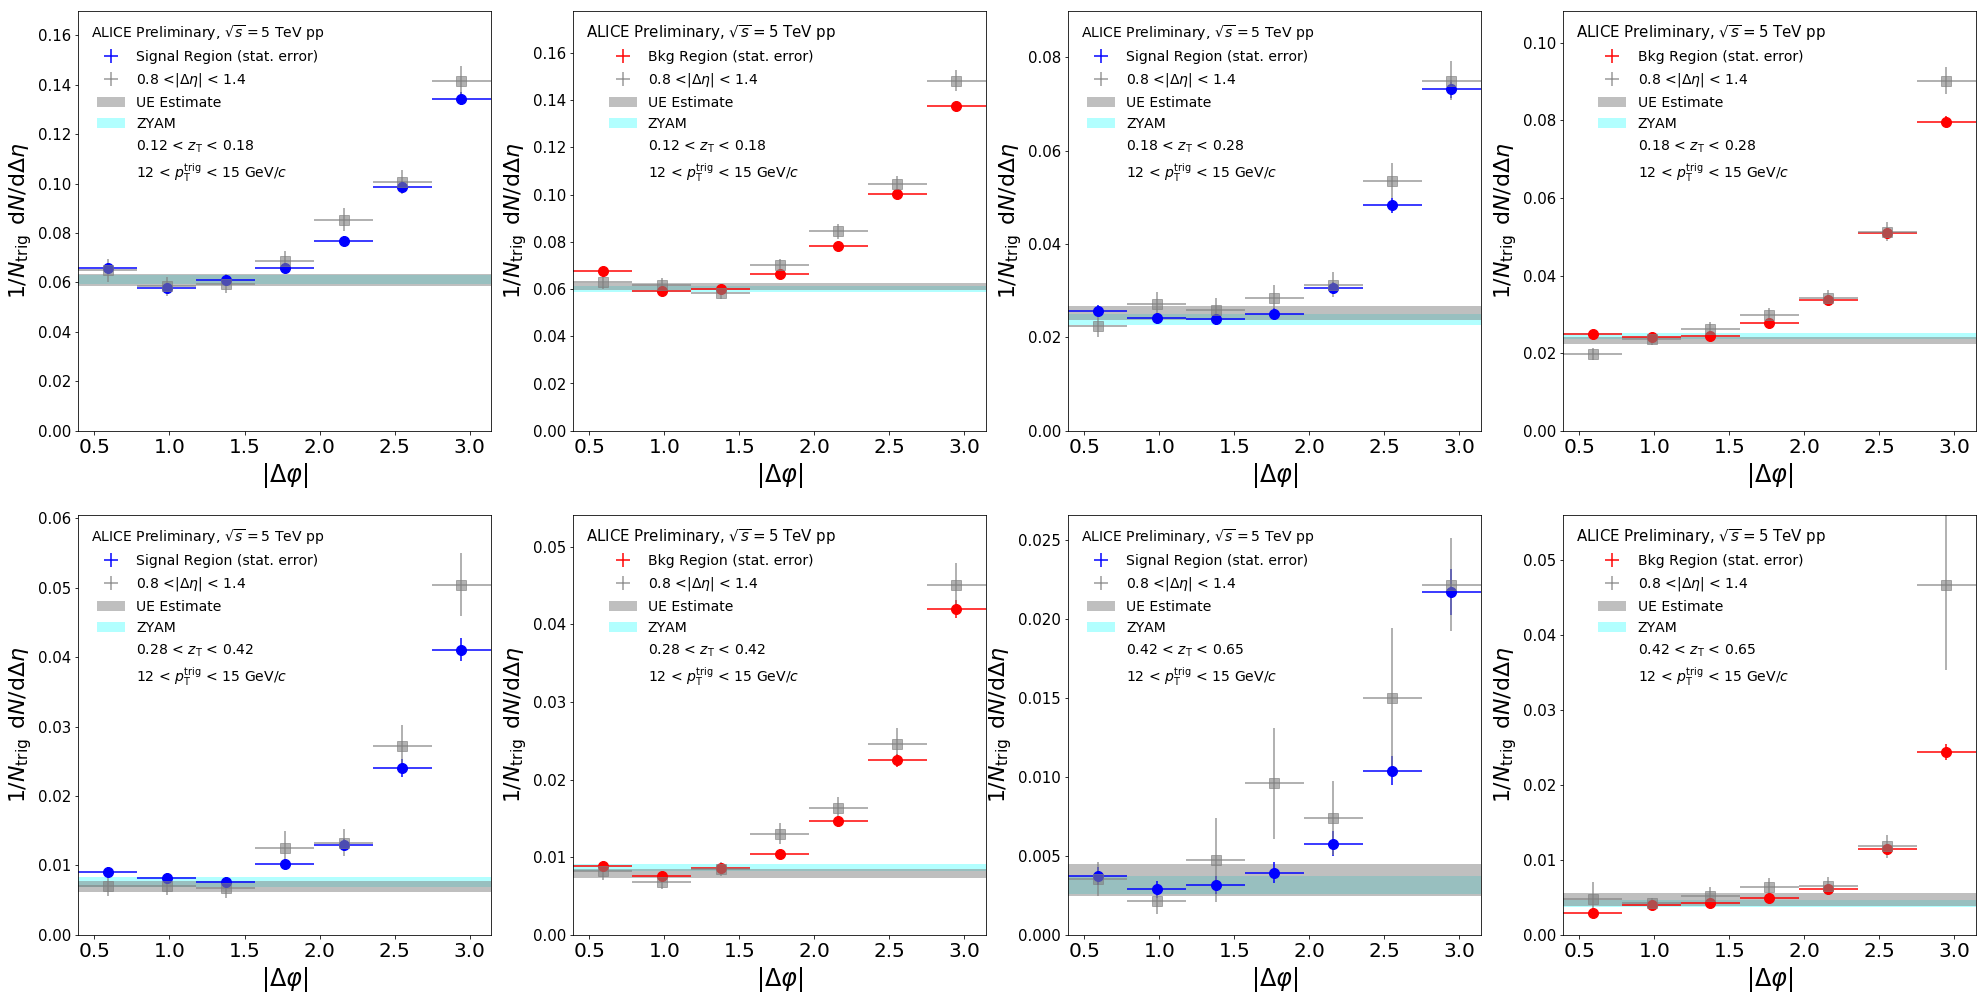

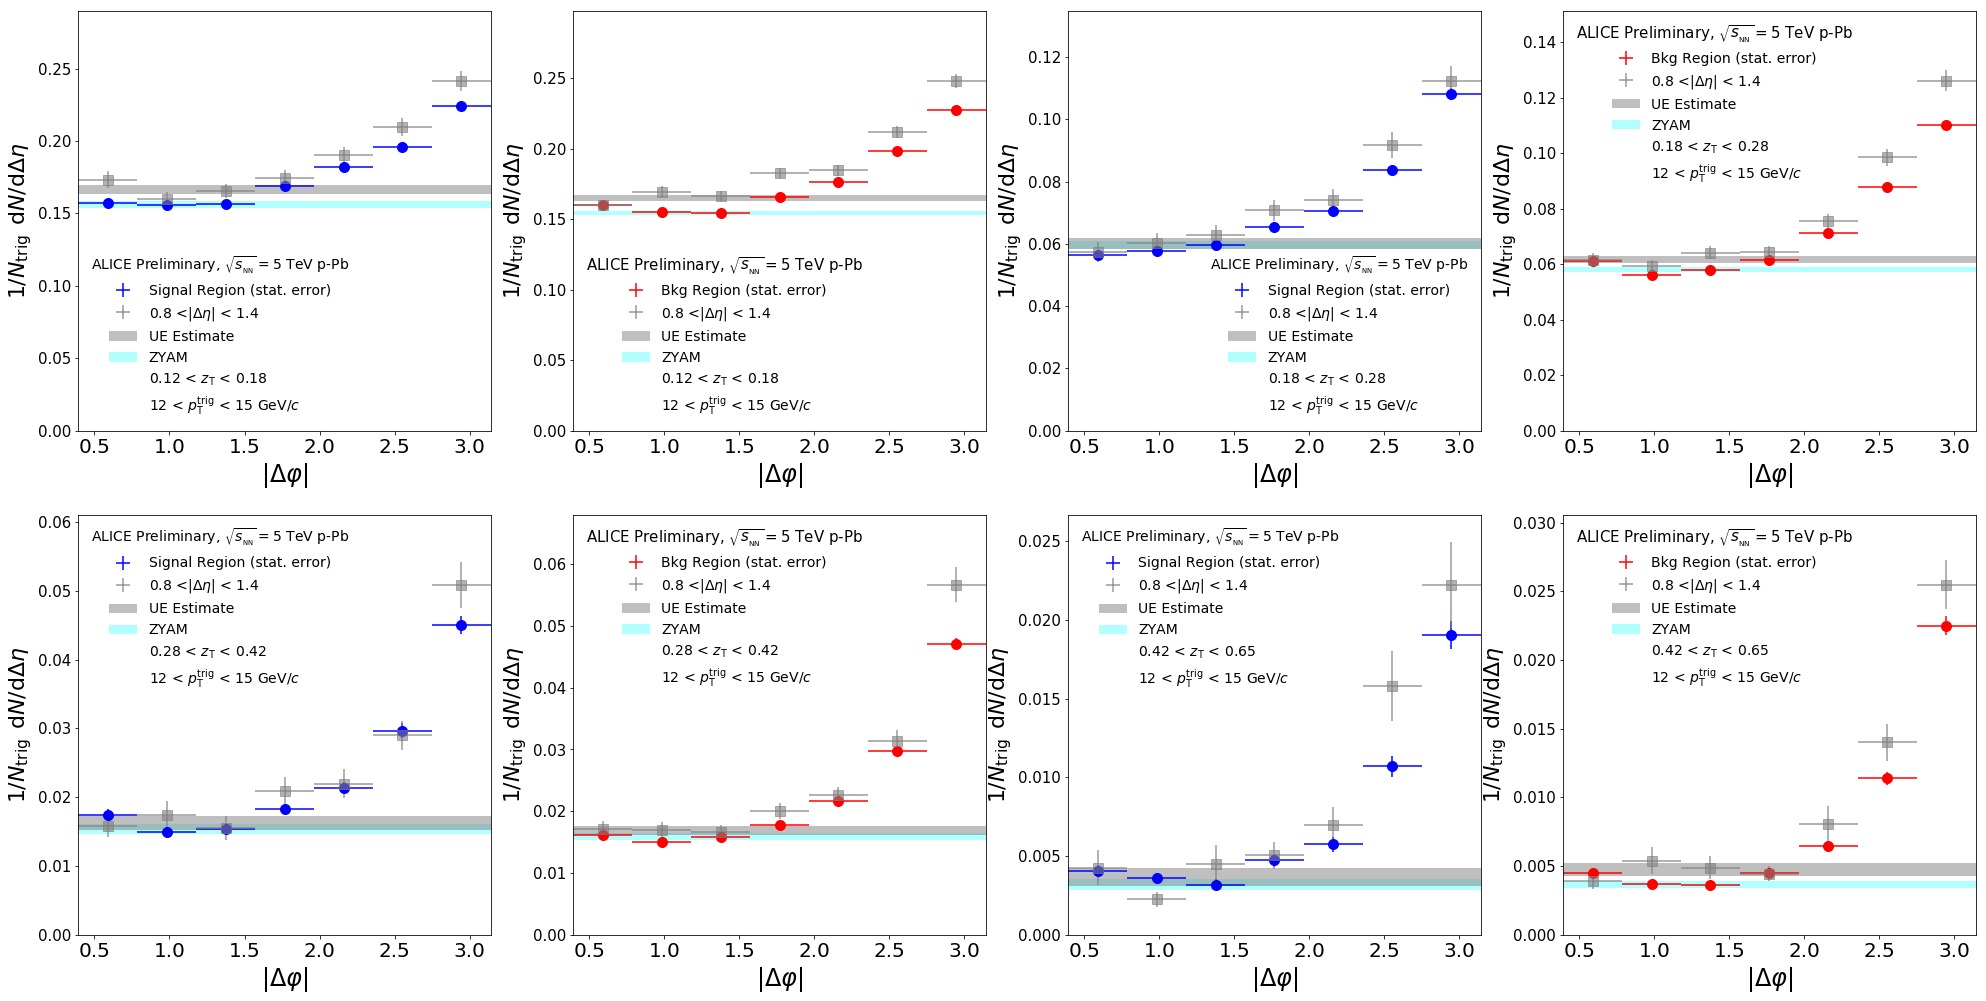

In [11]:
Systems = ["pp","p-Pb"]
Files = [pp_File,pPb_File]

for sys,ifile in zip(Systems,Files):
    print(" $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region")
    fig = plt.figure(figsize=(34,17))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            
            ztb = izt-zT_offset
            
            Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, True,False)
            Bkg_LE_Phi_Array, Bkg_LE_Error_Array = GetLEProj(ifile, ipt, izt, False,False)

            S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)
            Bkg_LE, Bkg_LE_Error = GetLE_Val(Bkg_LE_Phi_Array, Bkg_LE_Error_Array)


            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)


            Sig_Z_Value,Sig_Z_Error = ZYAM_Line(Sig_Phi_Array, Sig_Phi_Error_Array)
            Bkg_Z_Value,Bkg_Z_Error = ZYAM_Line(Bkg_Phi_Array, Bkg_Phi_Error_Array)

            print("%1.2f - %1.2f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.4f \\\\"
                  %(zTbins[izt],zTbins[izt+1],S_LE,S_LE_Error,Bkg_LE,Bkg_LE_Error,Sig_Z_Value,Sig_Z_Error,Bkg_Z_Value,Bkg_Z_Error))

                                            
                                        #--------------plot--------------------#
           
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
                
            fsize = 20

            #sig
            ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='b',label='Signal Region (stat. error)')

            ax.plot(delta_phi_centers,Sig_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)
            s_le_plot = ax.errorbar(delta_phi_centers,Sig_LE_Phi_Array,xerr=phi_width,yerr=Sig_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")

            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14159]
            s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
            s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Signal Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
                'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            #ax = fig.add_subplot(1,2,1)
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Bkg_LE_Phi_Array)))
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14149]
            b_z_line = plt.fill_between(fill_x, Bkg_Z_Value-Bkg_Z_Error,Bkg_Z_Value+Bkg_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
            b_le_line = plt.fill_between(fill_x, Bkg_LE-Bkg_LE_Error,Bkg_LE+Bkg_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            ax.plot(delta_phi_centers,Bkg_Phi_Array,'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,Bkg_Phi_Array,xerr=phi_width,yerr=Bkg_Phi_Error_Array,fmt=None,ecolor='r')

            plt.plot(delta_phi_centers,Bkg_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)

            b_le_plot =plt.errorbar(delta_phi_centers,Bkg_LE_Phi_Array,xerr=phi_width,yerr=Bkg_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8)
            leg = ax.legend([b_plot,b_le_plot,b_le_line,b_z_line,empt,empt2],['Bkg Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
                'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                loc='best',fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
            plt.setp(leg.get_title(),fontsize=15)
            fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')        
    print("")
    #return


Made the decision to not declare global np.arrays containing the plot data until after UE subtraction. This way there are only two sets of arrays for each system, background and signal regions with their errors (no LE or ZYAM data structures).

# Subtract UE and Start Using Global Arrays

In [12]:
 #Number of zT bins, subject to change

#Global Arrays
pp_CSR = np.zeros((NzT,len(delta_phi_centers)))
pp_CSR_Errors = np.zeros((NzT,len(delta_phi_centers)))
pp_CBR = np.zeros((NzT,len(delta_phi_centers)))
pp_CBR_Errors = np.zeros((NzT,len(delta_phi_centers)))

pPb_CSR = np.zeros((NzT,len(delta_phi_centers)))
pPb_CSR_Errors = np.zeros((NzT,len(delta_phi_centers)))
pPb_CBR = np.zeros((NzT,len(delta_phi_centers)))
pPb_CBR_Errors = np.zeros((NzT,len(delta_phi_centers)))

pp_LE_Error = np.zeros(NzT)
pPb_LE_Error = np.zeros(NzT)

for sys,ifile in zip(Systems,Files):
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
    else:
        SYS=sys
        
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, True,True) # Using AVERAGE LE
            Bkg_LE_Phi_Array, Bkg_LE_Error_Array = GetLEProj(ifile, ipt, izt, False,True) # Using AVERAGE LE

            S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)
            Bkg_LE, Bkg_LE_Error = GetLE_Val(Bkg_LE_Phi_Array, Bkg_LE_Error_Array)


            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)

            Sig_Phi_Array -= S_LE
            Bkg_Phi_Array -= Bkg_LE
            vars()["%s_CSR"%(SYS)][ztb] = Sig_Phi_Array
            vars()["%s_CSR_Errors"%(SYS)][ztb] = Sig_Phi_Error_Array
            
            vars()["%s_CBR"%(SYS)][ztb] = Bkg_Phi_Array
            vars()["%s_CBR_Errors"%(SYS)][ztb] = Bkg_Phi_Error_Array
            
            vars()["%s_LE_Error"%(SYS)][ztb] = S_LE_Error

# Plot UE Sub. with Uncertainties

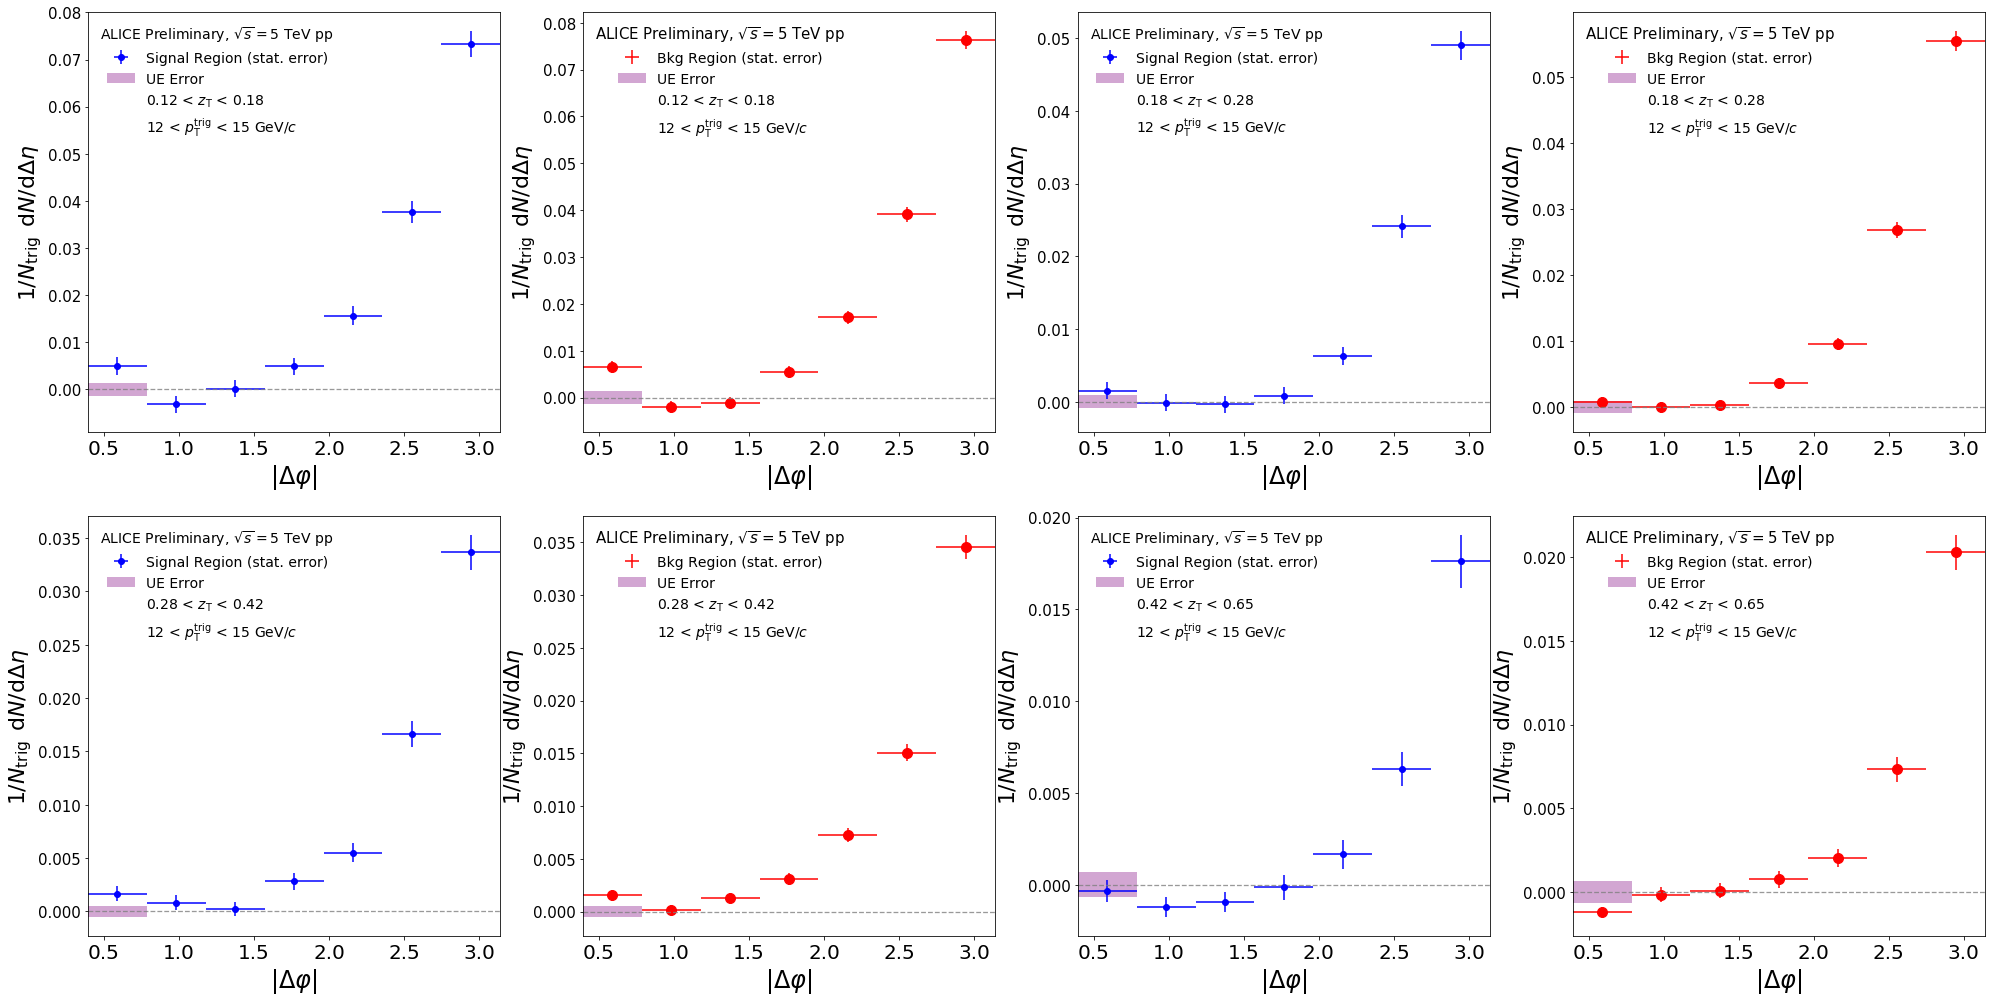

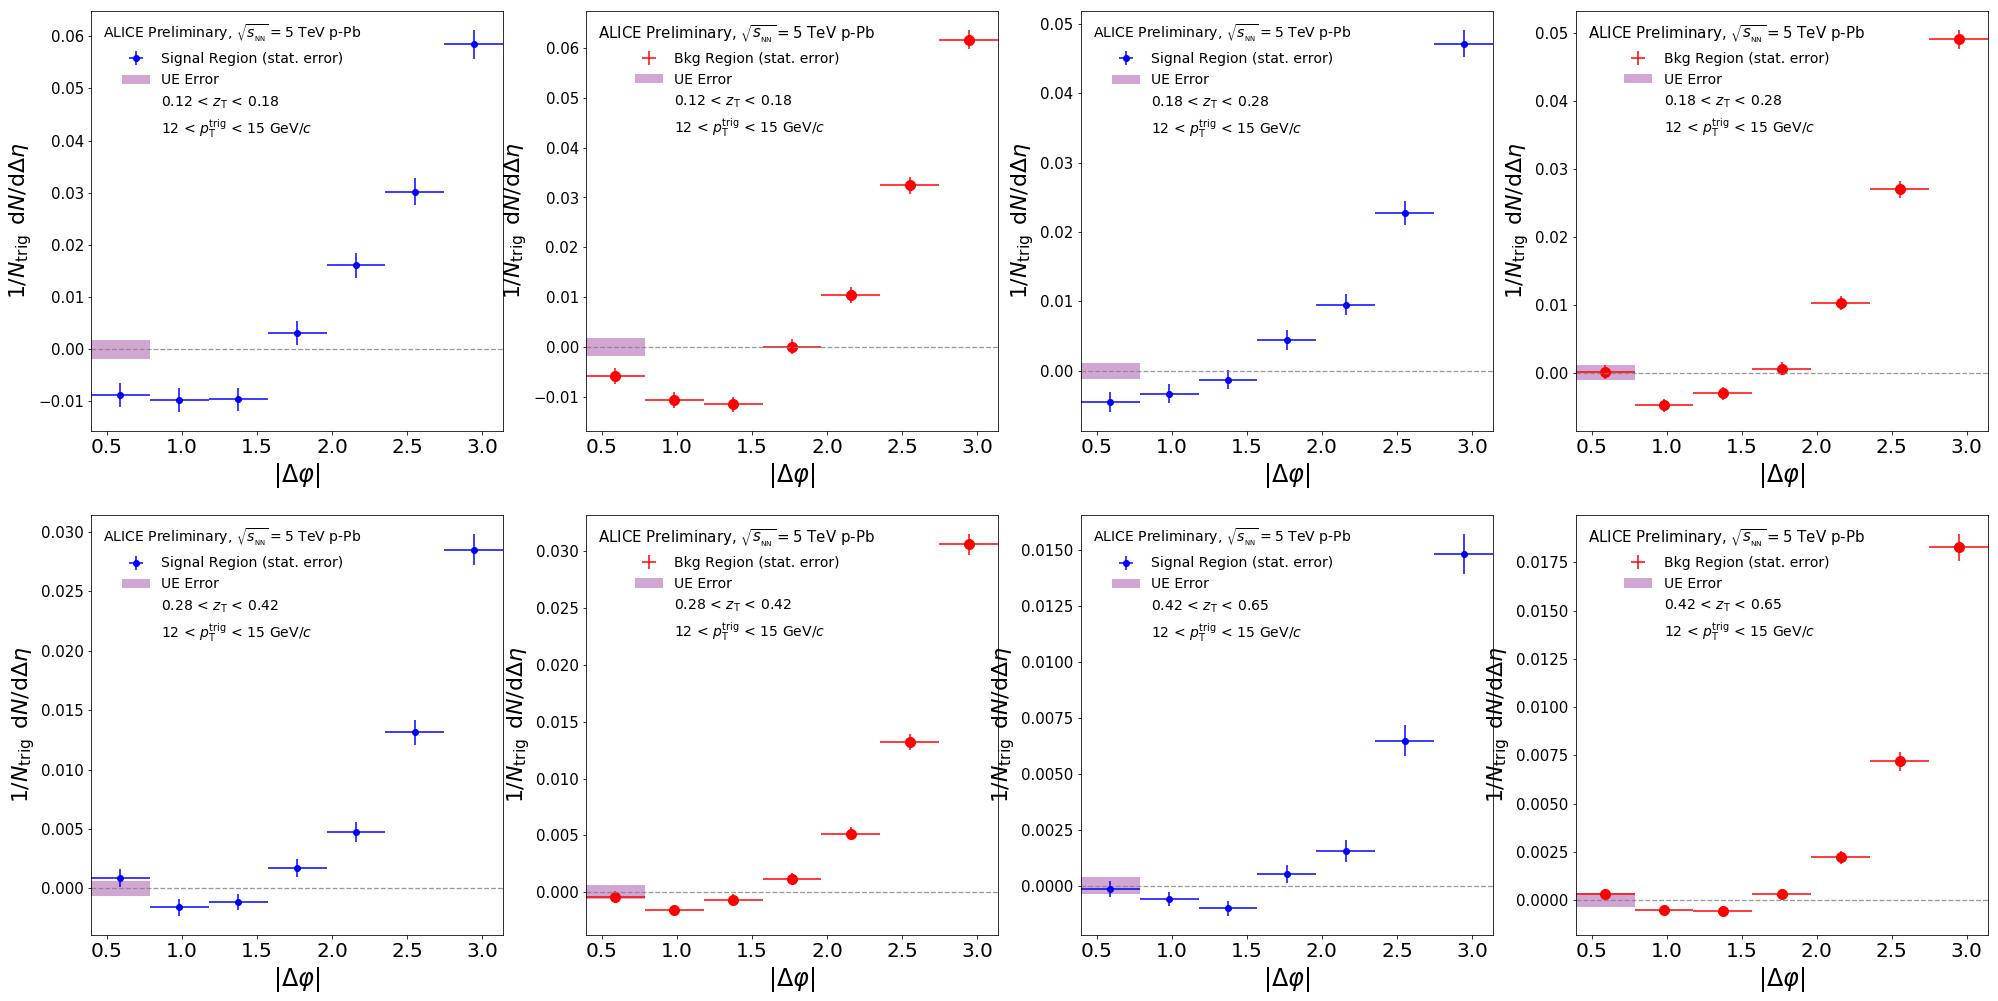

In [13]:
fsize = 20
for sys,ifile in zip(Systems,Files):
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
    else:
        SYS=sys
        
    fig = plt.figure(figsize=(34,17))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            #sig
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
            #ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ztb],fmt='bo',ecolor='b',label='Signal Region (stat. error)')
            
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],
                vars()["%s_LE_Error"%(SYS)][ztb],facecolor='purple',alpha=0.35) 
            
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)

            
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,UE_Band,empt,empt2],['Signal Region (stat. error)',"UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.yticks(fontsize=fsize-5)

            ax.plot(delta_phi_centers,vars()["%s_CBR"%(SYS)][ztb],'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,vars()["%s_CBR"%(SYS)][ztb],xerr=phi_width,yerr=vars()["%s_CBR_Errors"%(SYS)][ztb],fmt=None,ecolor='r')
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],vars()["%s_LE_Error"%(SYS)][ztb],facecolor='purple',alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)
            
            
            leg = ax.legend([b_plot,UE_Band,empt,empt2],['Bkg Region (stat. error)',"UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                loc='best',fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
            plt.setp(leg.get_title(),fontsize=15)
            fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')  

# Purity Scaling + Correlated Subtraction

## Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [14]:
pp_CSR = (pp_CSR - (1-purity)*pp_CBR)/purity
pPb_CSR = (pPb_CSR - (1-purity)*pPb_CBR)/purity

pp_CSR_Errors = pp_CSR_Errors/purity
pPb_CSR_Errors = pPb_CSR_Errors/purity

pp_LE_Error = pp_LE_Error/purity
pPb_LE_Error = pPb_LE_Error/purity

## Apply Corrections

In [15]:
def Apply_Corrections(Phi_Array):
   
    Efficiency = 0.85
    Correction_reduced = Corrections[zT_offset:NzT+zT_offset]
    oneminFake_reduced = oneminFake[zT_offset:NzT+zT_offset]
    
    #####  Single Track Efficiency  #####
    Phi_Array = Phi_Array/Efficiency
 
    for izt in range(4):
        
        #####  Track pT Binning Correction  #####
        temp_corr = Correction_reduced[izt]
        Phi_Array = Phi_Array*temp_corr

        ##### 1 - Fake Rate Correction. #####
        temp_fake = oneminFake_reduced[izt]
        Phi_Array = Phi_Array*temp_fake

In [16]:
for ztb in range (NzT):
    Apply_Corrections(pp_CSR[ztb])
    Apply_Corrections(pp_CSR_Errors[ztb])

    Apply_Corrections(pPb_CSR[ztb])
    Apply_Corrections(pPb_CSR_Errors[ztb])
    
    Apply_Corrections(pp_LE_Error[ztb])
    Apply_Corrections(pPb_LE_Error[ztb])

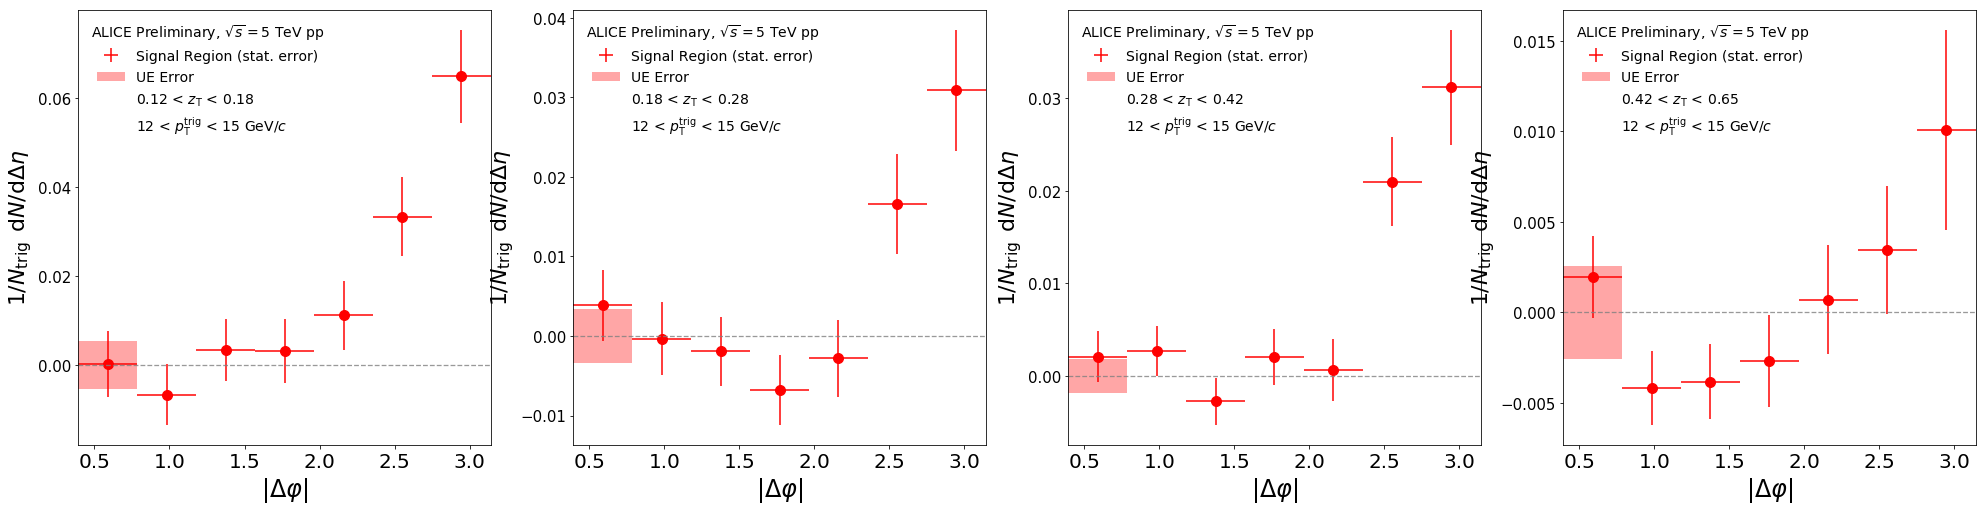

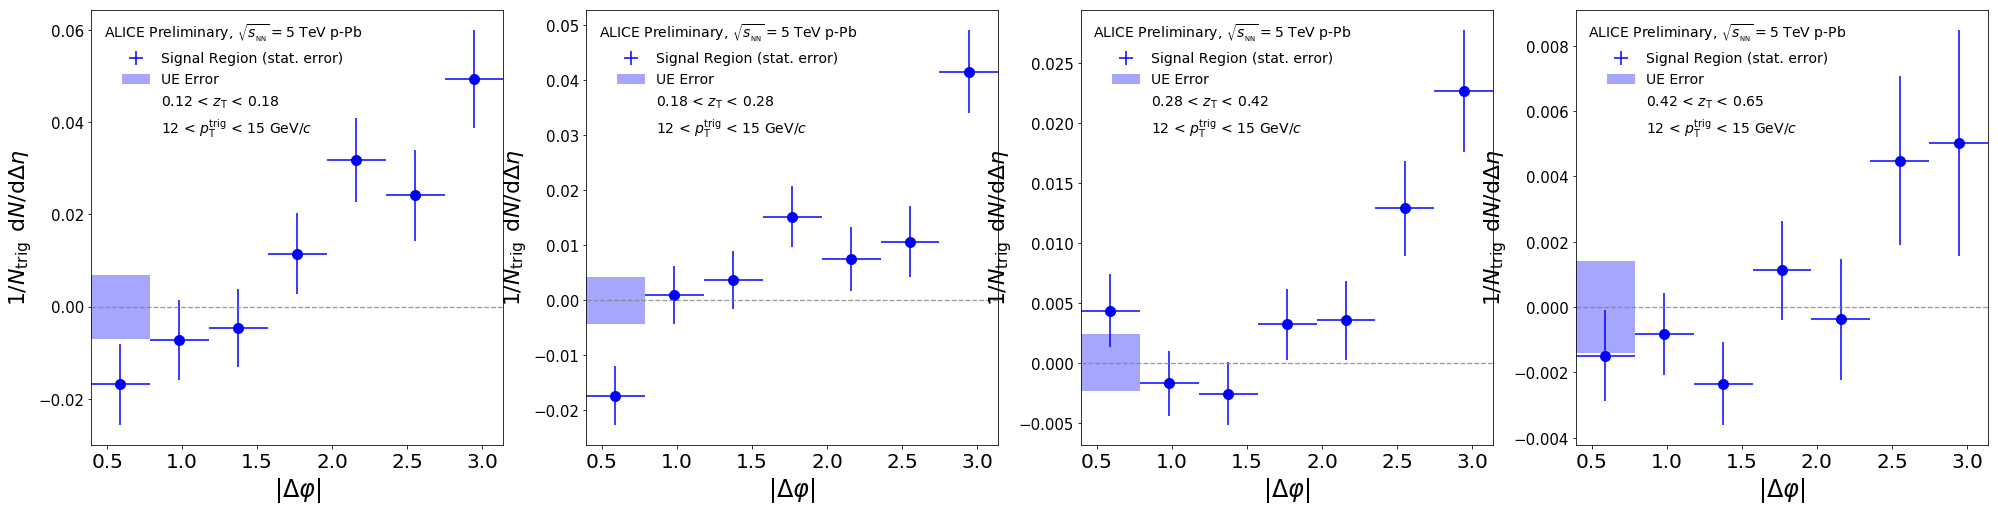

In [17]:
for sys,ifile in zip(Systems,Files):
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
        sys_color = 'blue'
    else:
        SYS=sys
        sys_color = 'red'
        
    fig = plt.figure(figsize=(34,8))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
        #sig
            if (NzT == 4):
                ax = fig.add_subplot(1,4,(ztb+1))
            elif (NzT == 6):
                ax = fig.add_subplot(1,6,(ztb+1))
            
            ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],'bo',color=sys_color,ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ztb],fmt=None,ecolor=sys_color,label='Signal Region (stat. error)')
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],vars()["%s_LE_Error"%(SYS)][ztb],facecolor=sys_color,alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)


            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            #plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,UE_Band,empt,empt2],['Signal Region (stat. error)',"UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)

# Overlay pp and p-Pb

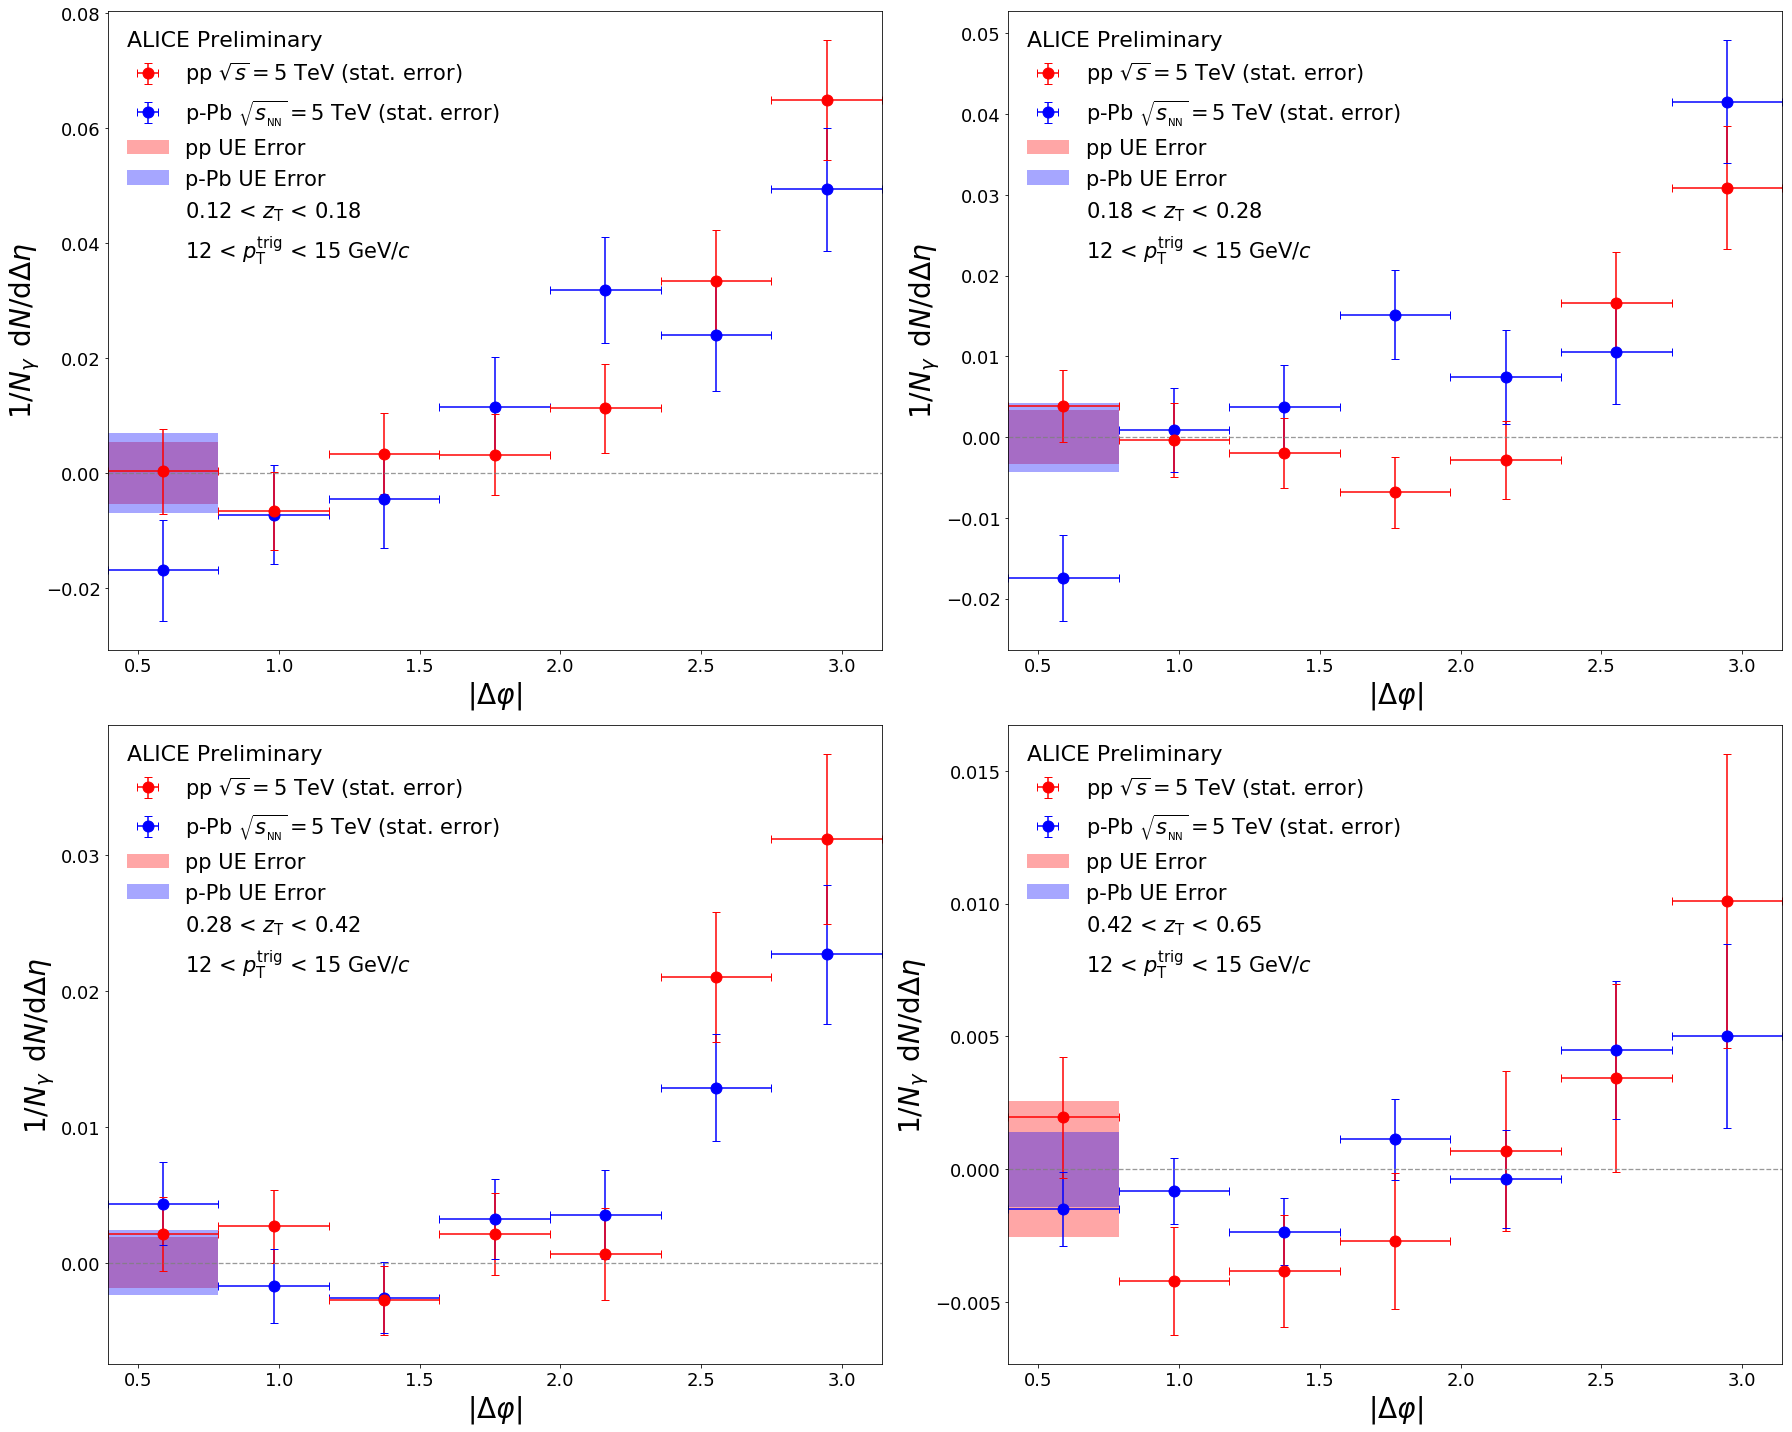

In [18]:
for ipt in range (3):
    if (ipt > 0): continue
    ipt = ipt+2
    fig = plt.figure(figsize=(25,20))
    for izt in range (zT_offset,NzT+zT_offset):
        ztb = izt-zT_offset

        if (NzT ==4):
            ax = fig.add_subplot(2,2,ztb+1)
        elif (NzT ==6):
            ax = fig.add_subplot(2,3,ztb+1)

        pPb = plt.errorbar(delta_phi_centers,pPb_CSR[ztb],xerr=phi_width,yerr=pPb_CSR_Errors[ztb],fmt='bo',capsize=4,markersize=11)
        pp = plt.errorbar(delta_phi_centers,pp_CSR[ztb],xerr=phi_width,yerr=pp_CSR_Errors[ztb],fmt='ro',capsize=4,markersize=11)

        plt.xlabel(r'|$\Delta \varphi$|',fontsize=28)
        plt.xticks(fontsize=18)
        plt.xlim((0.39269908169872414,3.14159))
        plt.ylabel(r'$1/N_{\gamma} \: \: \mathrm{d}N/\mathrm{d}\Delta \eta$',fontsize=28)
        plt.yticks(fontsize=18)
        plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)        
        
        pp_UE = ax.fill_between(ue_error_bar,-pp_LE_Error[ztb],pp_LE_Error[ztb],facecolor='red',alpha=0.35) #Other for pp
        pPb_UE = ax.fill_between(ue_error_bar,-pPb_LE_Error[ztb],pPb_LE_Error[ztb],facecolor='blue',alpha=0.35)#One for p-Pb
        
        empt, = ax.plot([], [],' ')
        empt2, = ax.plot([],[],' ')
        
        leg = plt.legend([pp,pPb,pp_UE,pPb_UE,empt,empt2],['pp $\sqrt{s}= 5$ TeV (stat. error)',
            'p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV (stat. error)', 'pp UE Error', 'p-Pb UE Error',
            r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
            r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],loc = "upper left",fontsize=21,frameon=False,numpoints=1)
       
        leg.set_title("ALICE Preliminary")
        leg._legend_box.align = "left"
        plt.setp(leg.get_title(),fontsize=22)
        fig.tight_layout()
        
    plt.show()
    #fig.savefig('pics/Gamma_hadron_corr_zT_%i.pdf'%(ztb))
    fig.savefig('pics/Gamma_hadron_corr.pdf')

### Systamitic Errors (Boxes = Type A)

In [19]:
pp_E_Shower = np.array([0.33,0.10,0.06,0.01])
pPb_E_Shower = np.array([0.05,0.04,0.005,0.01])

pp_sys = np.zeros(NzT)
pPb_sys = np.zeros(NzT)

pp_sys = np.sqrt(pp_E_Shower**2 + pp_LE_Error**2)
pPb_sys = np.sqrt(pPb_E_Shower**2 + pPb_LE_Error**2)    

# Fragmentation Function

In [20]:
def Integrate_Away_Side(Phi_array,Phi_Errors):
    
    Low_Phi_Bin = 3 #Corresponds to ∆phi > 2.1
    FF_zt = np.zeros(NzT)
    FF_zt_Errors = np.zeros(NzT)
    for izt in range(zT_offset,NzT+zT_offset):
        ztb = izt-zT_offset
        zT_width = zTbins[izt+1]-zTbins[izt]
        
        temp_phi = Phi_array[ztb][(len(Phi_Errors[ztb])-Low_Phi_Bin):len(Phi_array[ztb])]
        FF_zt[ztb] = temp_phi.sum()/zT_width
        
        temp_error = (Phi_Errors[ztb][(len(Phi_Errors[ztb])-Low_Phi_Bin):len(Phi_Errors[ztb])])**2
        FF_zt_Errors[ztb] = math.sqrt(temp_error.sum())/zT_width
    return FF_zt, FF_zt_Errors 

In [21]:
# NN_pp_FF = np.array([3.09208038, 4.06060791, 2.55636073, 0.754966, 0.40668246, 0.0860855])
# NN_pp_Error = np.array([1.00712306, 0.57571265, 0.30321927, 0.13821373, 0.06743482, 0.03615615])

# NN_pPb_FF = np.array([12.39342794, 7.37547956, 2.3925692, 0.91057808, 0.29133396, 0.0532953])
# NN_pPb_Error = np.array([1.19737744, 0.6651166, 0.31978294, 0.13846122, 0.05565065, 0.02261034])

# L0_pp_FF = np.array([3.57247865, 4.33031726, 2.9509478, 0.89608728, 0.48205601, 0.09990165])
# L0_pp_Error = np.array([1.18174165, 0.67436161, 0.35620501, 0.16348465, 0.08015733, 0.04290393])

# L0_pPb_FF = np.array([14.07293846, 7.08445849, 2.43431645, 0.97443936, 0.28721994, 0.04481062])
# L0_pPb_Error = np.array([1.36978768, 0.75748083, 0.36519239, 0.15894631, 0.06347339, 0.02589638])

# Avg_pp_FF = (NN_pp_FF+L0_pp_FF)/2
# Avg_pp_Error = np.sqrt(NN_pp_FF**2+L0_pp_FF**2)/2
# Delta_pp_FF = (NN_pp_FF-L0_pp_FF)/(NN_pp_FF+L0_pp_FF) #Taking half the diff as 1 sigma

# Avg_pPb_FF = (NN_pPb_FF + L0_pp_FF)/2
# Avg_pPb_Error = np.sqrt(NN_pPb_FF**2+L0_pPb_FF**2)/2
# Delta_pPb_FF = (NN_pPb_FF - L0_pPb_FF)/(NN_pPb_FF + L0_pp_FF)


In [22]:
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=10)

leg = plt.legend([pp_plot,pPb_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
    "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':15})
leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

NameError: name 'pp_FF' is not defined

In [ ]:
# MC_FF = [4.31955339009877, 4.221120762569847, 3.8513237598133423, 2.6958245155997327]
# MC_FF_Errors = [0.20744562679073691, 0.2152168981595775, 0.2379945692723888, 0.24741289559999502]

## p-Pb/pp Ratio

In [ ]:
plt.figure(figsize=(9,7))


E_Shower_Ratio = np.array([0.05,0.04,0.055,0.115])

Ratio = pPb_FF/pp_FF

Ratio_Error = np.sqrt((pPb_FF_Errors/pPb_FF)**2 + (pp_FF_Errors/pp_FF)**2)*Ratio

Ratio_Systematic = np.sqrt((pp_LE_Error/pp_FF)**2 + (pPb_LE_Error/pPb_FF)**2 + E_Shower_Ratio**2)*Ratio

Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

Sys_Box = [0.65,0.69]
xfill = [0.65,0.7]
Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

Ratio_Plot = plt.errorbar(zT_centers, Ratio, yerr=Ratio_Error,xerr=zT_widths, fmt='ko',capsize=3, ms=6,lw=1)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
plt.yticks(np.arange(-0, 2, step=0.2))
plt.xlim(xmin = 0.1,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')

plt.legend([Ratio_Plot,Sys_Plot,Norm_Box],["Statistical Error","Systematic Error","Normalization Error"],frameon=False,numpoints=1,title=' ',prop={'size':18})
plt.figtext(0.39,0.83,"ALICE Preliminary $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

plt.gcf()
plt.savefig("pics/NN_pp_FFunction.pdf", bbox_inches='tight')
plt.show()

## Jet Fragmentation Comparison

In [ ]:
##### Digitized by Fernando from paper #####
jet_5_10_x = np.array([0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.425,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.925])
jet_5_10_y = np.array([14.365,12.023,9.813,7.862,6.243,4.979,4.045,3.260,2.598,2.072,1.677,1.320,1.048,0.842,0.680,0.549,0.377])

jet_10_15_x = np.array([0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.875,0.925])
jet_10_15_y = np.array([23.185,17.108,12.583,9.358,6.987,5.213,3.956,2.233,1.637,1.304,1.007,0.774,0.597,0.454,0.370,0.284,0.219])

jet_5_10_y = jet_5_10_y*(1.0/6)
jet_10_15_y = jet_10_15_y*(1.0/6)

jet_5_10_x = jet_5_10_x*(2.0/3.0)
jet_10_15_x = jet_10_15_x*(2.0/3.0)

In [ ]:
plt.figure(figsize=(9,7))

jet1 = plt.errorbar(jet_5_10_x,jet_5_10_y,yerr=0,xerr=0.025,fmt='s',color='green',alpha=0.6,label=r'$p_T^{ch\ jet}$ 5-10GeV/c')
jet2 = plt.errorbar(jet_10_15_x,jet_10_15_y,yerr=0,xerr=0.025,fmt='cs',alpha=0.6,label=r'$p_T^{ch\ jet}$ 10-15GeV/c')

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
#plt.ylim(ymin = 0.01,ymax=10)

leg = plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
    r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$']
    ,frameon=False,numpoints=1,title=' ',loc="best",prop={'size':15})

#plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp","p-Pb",r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$'],frameon=False,numpoints=1,title='',prop={'size':12})
leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

# Gustavo pp 7 TeV Comparison

In [ ]:
file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")

plot = False
if (plot):
    c = ROOT.TCanvas("c","c",2000,1000)
    pp7.Draw()
    pp7_sys.SetFillColor(0)
    ROOT.gPad.SetLogy()
    pp7_sys.SetLineColor(1)
    pp7_sys.Draw("sameE2")
    c.Draw()
    
nbins = pp7.GetSize()-2 
pp7_data = np.zeros(nbins)
pp7_x = np.zeros(nbins)
pp7_error = np.zeros(nbins)
pp7_width = np.zeros(nbins)
pp7_Sys = np.zeros(nbins)

for i in range (1,nbins+1):
    pp7_data[i-1] = pp7.GetBinContent(i)
    pp7_x[i-1] = pp7.GetBinCenter(i)
    pp7_error[i-1] = pp7.GetBinError(i)
    pp7_width[i-1] = pp7.GetXaxis().GetBinWidth(i)/2
    pp7_Sys[i-1] = pp7_sys.GetBinError(i)


In [ ]:
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)



pp7_bar = plt.bar(pp7_x,pp7_Sys+pp7_Sys, bottom = pp7_data-pp7_Sys, width = 0.03,align='center',edgecolor='green',color='white')
pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white')
#pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white')

pp7_plot = plt.errorbar(pp7_x,pp7_data,xerr = pp7_width,yerr= pp7_error,linewidth=1,fmt = 'go',capsize=1,label = 'pp7')
pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
#pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.7)

leg = plt.legend([pp_plot,pp7_plot],["pp $\sqrt{s} = 5$ TeV","pp $\sqrt{s} = 7$ TeV"]
    ,frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':15})
leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

# Fragmentation Function

In [ ]:
def FF(File,prfx,DoSysB=False):
    zT_integral = []
    zT_point = []
    zT_error = []

    Sys_TypeA = []
    Sys_TypeB = []
    
    WantRatio = True
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    E_Shower = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    if (prfx == "pp"):
        E_Shower = [0.0,0.0,0.33,0.10,0.06,0.01,0.0]
    if (prfx == "13def"):
        E_Shower = [0.0,0.0,0.05,0.04,0.0,0.01,0.0]
        
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2

        for ztbin in range(7):
            izt = ztbin
            if (prfx == '18b10a'):
                #hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,False,False)#doZYAM,doSubtraction,dosys                                                                                                                                                                                                                                                                                                                                                                                                                                                      
                hsig = GetPhiProj(File,prfx,ptbin,ztbin,True,True,False)
            else:
                hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)#doZYAM,doSubtraction,dosys                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)
            Phi_bin_min = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi)
            #zT_point.append((zTbins[ztbin]+zTbins[ztbin+1])/2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            zT_width = zTbins[ztbin+1]-zTbins[ztbin]
            temp_int = hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi))

            #temp_int = hsig.Integral(hsig.GetXaxis().FindBin(math.pi/2),hsig.GetXaxis().FindBin(math.pi))                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            #print temp_int                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

            if (prfx == 'pp'):
                Sys_TypeA.append(math.sqrt(pp_LE_Error[izt]**2))
                Sys_TypeB.append(math.sqrt(pp_Eff_Error[izt]**2))
            elif (prfx == '13def'):
                Sys_TypeA.append(math.sqrt(pPb_LE_Error[izt]**2))
                Sys_TypeB.append(math.sqrt(pPb_Eff_Error[izt]**2))
            if (prfx == '18b10a'):
                Sys_TypeA.append(math.sqrt(MC_LE_Error[izt]**2 + MC_Eff_Error[izt]**2))
                Sys_TypeB.append(0)

            #errors                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
            zt_tmp_e = 0.0
            if not(DoSysB):
                for phibin in range(Phi_bin_min+1, Phi_bin_max):
                    zt_tmp_e += (hsig.GetBinError(phibin))**2
                zt_tmp_e = math.sqrt(zt_tmp_e)
                zt_tmp_e = zt_tmp_e*Corrections[ztbin]
                zt_tmp_e = zt_tmp_e*oneminFake[ztbin]
                if (WantRatio):
                    #zt_tmp_e = math.sqrt(zt_tmp_e**2+Sys_TypeA[ztbin]**2)/zT_width
                    zt_tmp_e = math.sqrt(zt_tmp_e**2)/zT_width
                else:
                    zt_tmp_e = math.sqrt(zt_tmp_e**2+Sys_TypeA[ztbin]**2 + (0.051*temp_int)**2 + (E_Shower[ztbin]*zT_width)**2)/zT_width
                #print "Stat. Error on FF for ",prfx," = ",zt_tmp_e
                

            else:
                if not(prfx=="18b10a"):
                    if (WantRatio):
                        Sys_TypeB[ztbin] = math.sqrt(Sys_TypeB[ztbin]**2)
                    else:
                        Sys_TypeB[ztbin] = math.sqrt(Sys_TypeB[ztbin]**2 + (0.25*temp_int)**2 )
                zt_tmp_e = Sys_TypeB[ztbin]/zT_width
                zt_tmp_e = zt_tmp_e*Corrections[ztbin]
                zt_tmp_e = zt_tmp_e*oneminFake[ztbin]
                #zt_tmp_e = math.sqrt(zt_tmp_e**2+E_Shower[ztbin])

            #print 'uncorrected integral = ',temp_int
            temp_int = temp_int/zT_width
            temp_int = temp_int*Corrections[ztbin]
            temp_int = temp_int*oneminFake[ztbin]
            zT_error.append(zt_tmp_e)
            zT_integral.append(temp_int)
        #print zT_error
    return zT_integral,zT_error
                                                                  

# Loop All FF

In [ ]:
## MC_int, MC_error = FF(MC_File,'18b10a',False)
MC_int,MC_LE_error = FF(MC_File,'18b10a',True)
print "hi"
#print MC_error
zT_point = []
zT_width = []
pp_min = []
pp_max = []


pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)
for ztbin in range(NzT):
    zT_point.append((zTbins[ztbin]+ zTbins[ztbin+1])/2)
    zT_width.append((zTbins[ztbin+1]-zTbins[ztbin])/2)
    pp_max.append(pp_int[ztbin]*1.25)
    pp_min.append(pp_int[ztbin]*0.75)
    #MC_error[ztbin] = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)
print zT_point
print zT_width

Compare_Jets = False

file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")
#pp7_sys.SetLineColor(1)
#pp7_sys.Draw("sameE2")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
nbins = pp7.GetSize()-2
print nbins
pp7_data = []
pp7_x = []
pp7_error = []
pp7_width = []
pp7_Sys = []
#pp7.Scale(6.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
for i in range (2,nbins-1):
    #print i,pp7.GetBinCenter(i)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    pp7_data.append(pp7.GetBinContent(i))
    pp7_x.append(pp7.GetBinCenter(i))
    pp7_error.append(pp7.GetBinError(i))
    pp7_Sys.append(pp7_sys.GetBinError(i))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    pp7_width.append(pp7.GetXaxis().GetBinWidth(i)/2)
#print "width ",pp7_width                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
#print pp7_x                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

#Lambda                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
#pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
#pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

#GetBKGsubtracted(File2,prfx2,ptbin,ztbin,DoZYAM,DoSub,DoSys)

pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)

#pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
#pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


#pPb NN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
# pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
# pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

pPb_int, pPb_error = FF(pPb_File,'13def',False)
pPb_int_sys, pPb_error_sys = FF(pPb_File,'13def',True)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
pPb_int = pPb_int[2:6]
pPb_error = pPb_error[2:6]
pPb_int_sys =pPb_int_sys[2:6]
pPb_error_sys = pPb_error_sys[2:6]
pp_int = pp_int[2:6]
pp_error = pp_error[2:6]
pp_int_sys = pp_int_sys[2:6]
pp_error_sys =  pp_error_sys[2:6]
MC_int = MC_int[2:6]
#MC_error = MC_error[2:6]
MC_LE_error = MC_LE_error[2:6]
pp_min = pp_min[2:6]
pp_max = pp_max[2:6]

zT_point = zT_point[2:6]
zT_width = zT_width[2:6]
#MC_int, MC_error = FF(MC_File,'18b10a',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
#MC_int,MC_LE_error = FF(MC_File,'18b10a',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#MC_error = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


pp_int = [2.7585,0.8295,0.4015,0.0777]
pp_error = [0.241,0.11355,0.05355,0.01555]
pPb_int = [2.3030,0.9015,0.28,0.0489]
pPb_error = [0.245,0.1065,0.043,0.0155]

print "MC: ",MC_int
print "pp: ",pp_int
print "pp Error: ",pp_error
print "pPb ",pPb_int
print "pPb Error: ",pPb_error
#HARDCODED DUE TO VERY SLIGHTLY DIFFERENT TREATMENT OF UE in MC (NO SIGNAL/BACKGROUND AVERAGE), NEED TO IMPLEMENT FLAG                                                                                                                                                                                                                                                                                                                                                                                                                                                      
#MC_int = [11.310060491732425, 7.218237175683422, 3.3433128788925974, 1.493177381233851, 0.4219207415978905, 0.21746230788120627,0.14140750410259098]                                                                                                                                                                                                                                                                                                                                                                                                                       
#MC_int = [10.144789996230653, 7.015105856903631, 3.515205460316105, 1.3819702542411194, 0.34675022023361635, 0.22417399972941549]                                                                                                                                                                                                                                                                                                                                                                                                                                          
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
#Jets


if (Compare_Jets):
    jet1 = plt.errorbar(jet_5_10_x,jet_5_10_y,yerr=0,xerr=0.025,fmt='s',color='green',alpha=0.6,label=r'$p_T^{ch\ jet}$ 5-10GeV/c')
    jet2 = plt.errorbar(jet_10_15_x,jet_10_15_y,yerr=0,xerr=0.025,fmt='cs',alpha=0.6,label=r'$p_T^{ch\ jet}$ 10-15GeV/c')

#pPb
dx = 0.03
x = np.asarray(zT_point)
y = np.asarray(pPb_int)
ex = np.ones(x.shape) * dx
#ey = y*0.15    # e.g. a 15% uncertainty
ey = np.asarray(pPb_Sys)
pPb_bar = plt.bar(x, ey+ey, bottom=y-ey, width=ex, align='center',edgecolor="blue",color='white',)

#pp
dxp = 0.03
xp = np.asarray(zT_point)
yp = np.asarray(pp_int)
exp = np.ones(xp.shape) * dxp
#ey = y*0.15    # e.g. a 15% uncertainty
eyp = np.asarray(pp_Sys)
pp_bar = plt.bar(xp, eyp+eyp, bottom=yp-eyp, width=exp, align='center',edgecolor="red",color='white',)
    
pp_plot = plt.errorbar(zT_point, pp_int,xerr=zT_width,yerr=pp_error,linewidth=1,fmt='ro',capsize=1,label='pp')
#plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue',label="pp Systematic")
#plt.fill_between(zT_point, pp_min, pp_max,interpolate=True, alpha=0.5,facecolor='blue')
#plt.errorbar(zT_point, pp_int, yerr=pp_error, fmt='k.',capsize=2)

#plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
#plt.fill_betweenx(pp_int,np.asarray(zT_point)-np.asarray(zT_width),np.asarray(zT_point)+np.asarray(zT_width), alpha=0.5)                                                                                                                                                                                                                                                                                                                                                                                                                                                   

pPb_plot = plt.errorbar(zT_point, pPb_int,xerr=zT_width,yerr=pPb_error,linewidth=1, fmt='bo',capsize=1,label='p-Pb')
#plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
#plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='k.',capsize=2)

#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red',label="p-Pb Systematic")


#Removed for preliminary
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.03,fmt='g.-',capsize=2)
#plt.fill_between(pp7_x,np.asarray(pp7_data)-np.asarray(pp7_Sys),np.asarray(pp7_data)+np.asarray(pp7_Sys),interpolate=False, alpha=0.5,facecolor='green')
#plt.fill_between(zT_point, np.asarray(MC_int)-np.asarray(MC_error), np.asarray(MC_int)+np.asarray(MC_error),interpolate=False, alpha=0.5,facecolor='cyan')                                                                                                                                                                                                                                                                                                                                                                                                                 


#plt.plot(zT_point,MC_int,'co')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
plt.yscale('log')
#plt.xscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
#plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
##plt.xlabel(r"$z_{\mathrm{T}} = \frac{p_\mathrm{T}^{\mathrm{h}}}{p_\mathrm{T}^\gamma},$ $\frac{2}{3} \ \frac{p_\mathrm{T}^{\mathrm{h}}}{p_\mathrm{T}^{\mathrm{ch \ jet}}} $",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=4)
# plt.figtext(0.65,0.751,"pPb $\sigma_{long}$ Data",color='Red', fontsize=15)
# plt.figtext(0.67,0.7,"pp $\sigma_{long}$ Data",color='Blue', fontsize=15)
#plt.figtext(0.65,0.751,"pPb Data",color='Red', fontsize=15)
#plt.figtext(0.65,0.7,"pp Data",color='Blue', fontsize=15)



#plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp","p-Pb",r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$'],frameon=False,numpoints=1,title='',prop={'size':12})
plt.legend([pp_plot,pPb_plot,pp_bar,pPb_bar],["pp $\sqrt{s_{\mathrm{_{NN}}}} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","pp Systematic","p-Pb Systematic"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':11})
P_x = [0.1]
P_One = [1]
P_E = [0.25]
#plt.errorbar[P_x,P_One,yerr=P_E,linewidth=1]

#plt.figtext(0.65,0.57,"$\sigma_{purity}$",color="Black",fontsize=20)
plt.figtext(0.58,0.52,"Normalization $\pm 25\%$",color='Black', fontsize=13)
#plt.figtext(0.55,0.2,"Jet Normalization 1/6",color='Black', fontsize=12)
#plt.figtext(0.55,0.15,"$\mathrm{\gamma}$-h Normalization $\pm 25\%$",color='Black', fontsize=12)
plt.figtext(0.55,0.83,"ALICE Preliminary",color='Black', fontsize=15)



#plt.figtext(0.65,0.802,"pythia $\gamma$-j pp",color='Cyan', fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
#plt.figure.set_size_inches(18.5, 10.5)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
#plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.gcf()
#plt.savefig("pics/Jet_FFunction.pdf", bbox_inches='tight')
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()


## Compare Shower Shape FF

In [ ]:
MC_int, MC_error = FF(MC_File,'18b10a',False)
MC_int,MC_LE_error = FF(MC_File,'18b10a',True)
print "hi"
print MC_error
zT_point = []
zT_width = []
pp_min = []
pp_max = []
pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)
for ztbin in range(NzT):
    zT_point.append((zTbins[ztbin]+ zTbins[ztbin+1])/2)
    zT_width.append((zTbins[ztbin+1]-zTbins[ztbin])/2)
    pp_max.append(pp_int[ztbin]*1.25)
    pp_min.append(pp_int[ztbin]*0.75)
    #MC_error[ztbin] = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)
print zT_point
print zT_width


file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")
#pp7_sys.SetLineColor(1)
#pp7_sys.Draw("sameE2")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
nbins = pp7.GetSize()-2
print nbins
pp7_data = []
pp7_x = []
pp7_error = []
pp7_width = []
pp7_Sys = []
#pp7.Scale(6.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
for i in range (2,nbins-1):
    #print i,pp7.GetBinCenter(i)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    pp7_data.append(pp7.GetBinContent(i))
    pp7_x.append(pp7.GetBinCenter(i))
    pp7_error.append(pp7.GetBinError(i))
    pp7_Sys.append(pp7_sys.GetBinError(i))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    pp7_width.append(pp7.GetXaxis().GetBinWidth(i)/2)

pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

pPb_int, pPb_error = FF(pPb_File,'13def',False)
pPb_int_sys, pPb_error_sys = FF(pPb_File,'13def',True)
                                                                         
pPb_int = pPb_int[2:6]
pPb_error = pPb_error[2:6]
pPb_int_sys =pPb_int_sys[2:6]
pPb_error_sys = pPb_error_sys[2:6]
pp_int = pp_int[2:6]
pp_error = pp_error[2:6]
pp_int_sys = pp_int_sys[2:6]
pp_error_sys =  pp_error_sys[2:6]
MC_int = MC_int[2:6]
MC_error = MC_error[2:6]
MC_LE_error = MC_LE_error[2:6]
pp_min = pp_min[2:6]
pp_max = pp_max[2:6]

zT_point = zT_point[2:6]
zT_width = zT_width[2:6]
#MC_int, MC_error = FF(MC_File,'18b10a',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
#MC_int,MC_LE_error = FF(MC_File,'18b10a',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#MC_error = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

print "MC: ",MC_int
print "pp: ",pp_int
print "pPb: ",pPb_int


L0_pp =  [2.7427184781952936, 0.8753815097422311, 0.429033119868042, 0.08060577353743517]
L0_pp_E = [0.45316117125988203, 0.16957729598601515, 0.0889978962352422, 0.03006821690151471]
L0_pPb = [2.3260559363976294, 0.9310683709971448, 0.2758857851603638, 0.04437041594268927]
L0_pPb_E = [0.30593559272871085, 0.13619726138047716, 0.050403919898293285, 0.020346281808276027]

                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.errorbar(zT_point, pp_int,xerr=zT_width,yerr=pp_error,linewidth=1,fmt='o',capsize=1,label='pp NN Data')
#plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue',label="pp Systematic")

plt.errorbar(zT_point, pPb_int,xerr=zT_width,yerr=pPb_error,linewidth=1, fmt='o',capsize=1,label='pPb NN Data')
#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red',label="p-Pb Systematic")

plt.errorbar(zT_point, L0_pp,xerr=zT_width,yerr=L0_pp_E,linewidth=1, fmt='o',capsize=1,label='pp $\sigma_{long}^2$ Data')

plt.errorbar(zT_point, L0_pPb,xerr=zT_width,yerr=L0_pPb_E,linewidth=1, fmt='o',capsize=1,label='pPb $\sigma_{long}^2$ Data')


#Removed for preliminary
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.03,fmt='g.-',capsize=2)
#plt.fill_between(pp7_x,np.asarray(pp7_data)-np.asarray(pp7_Sys),np.asarray(pp7_data)+np.asarray(pp7_Sys),interpolate=False, alpha=0.5,facecolor='green')
#plt.fill_between(zT_point, np.asarray(MC_int)-np.asarray(MC_error), np.asarray(MC_int)+np.asarray(MC_error),interpolate=False, alpha=0.5,facecolor='cyan')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T} d\Delta\eta}$",fontsize=20)
plt.xlabel("${z_T} = p_T^{h}/p_T^\gamma$",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.65)
plt.ylim(ymin = 0.01,ymax=4)




plt.legend(frameon=False,numpoints=1,prop={'size':12})

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
plt.title('Integrated $\gamma$-Hadron Correlation: $2\pi/3 < \Delta\phi < \pi, |\Delta\eta| < 0.6$ ')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.gcf()
plt.savefig("pics/Shower_FFunction.pdf", bbox_inches='tight')
plt.show()



## Fit pPb

In [ ]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()#(6,np.asarray(zT_point),np.asarray(pPb_int),np.asarray(z_error),np.asarray(pPb_error)))
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i
    pPb_Fit_Plot.SetPoint(i,zT_point[izt],pPb_int[izt])
    pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")

pPb_canv = ROOT.TCanvas("pPbcan","pPbcan",500,500)
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
latex.DrawLatex(0.78,0.85, "#color[4]{pPb}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9.9 #pm 0.8}")
ROOT.gPad.SetLogy()
pPb_canv.Update()
pPb_canv.Draw()
pPb_canv.SaveAs("pics/pPb_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

## Fit pp

In [ ]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.DrawLatex(0.81,0.85, "#color[4]{pp}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -8.3 #pm 0.8}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

# Fit Jets

In [ ]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()
pPb_Fit_Plot2 = ROOT.TGraphErrors()
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (17):
    izt = i
    pPb_Fit_Plot.SetPoint(i,jet_10_15_x[i],jet_10_15_y[i])
    pPb_Fit_Plot2.SetPoint(i,jet_5_10_x[i],jet_5_10_y[i])
    #pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")
pPb_Fit_Plot2.Fit("expo")

pPb_canv2 = ROOT.TCanvas("pPbcan2","pPbcan2",1000,500)
pPb_canv2.Divide(2,1)
pPb_canv2.cd(1)
ROOT.gPad.SetLogy()
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
#pPb_Fit_Plot.GetXaxis().SetRangeUser(0,1)
#pPb_Fit_Plot.GetYaxis().SetRangeUser(0.01,20)
latex.DrawLatex(0.5,0.85, "#color[4]{10-15 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9 #pm 0.06}")



pPb_canv2.cd(2)
pPb_Fit_Plot2.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot2.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot2.GetXaxis().CenterTitle(1)
pPb_Fit_Plot2.GetYaxis().CenterTitle(1)
pPb_Fit_Plot2.Draw("AP")
latex.DrawLatex(0.6,0.85, "#color[4]{5-10 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -6.4 #pm 0.07}")



ROOT.gPad.SetLogy()
pPb_canv2.Update()
pPb_canv2.Draw()
pPb_canv2.SaveAs("pics/Jet_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

# Divide FF

In [ ]:
#pPb/pp                                                                                                                                                                                                         
Ratio = []
Ratio_Error = []
whole = [0.65,0.69]
zT_point2 = []
zT_width2 = []

#Obtained with deta < 0.6, LE, and Uncorrected Purity
E_Shower_Ratio = [0.05,0.04,0.055,0.115]
Ratio_Shower_Average = [0.9,1.10,0.7,0.61]
Ratio_Shower_Stat = [0.1285,0.199,0.144,0.293]
Ratio_Sys = []
UE_Rel = [0.0179,0.0214,0.0269,0.0488]
UE_Error = []

DoShowerAverage=True

#E_Shower_pp = [0.33,0.10,0.06,0.01]
#E_Shower_pPb = [0.05,0.04,0.0,0.01]
xfill = [0.65,0.7]
for ztbin in range (4):
    #pp_error[ztbin] = math.sqrt(pp_error[ztbin]**2 - E_Shower_pp[ztbin]**2)
    #pPb_error[ztbin] = math.sqrt(pPb_error[ztbin]**2 - E_Shower_pPb[ztbin]**2)
    #Ratio.append(pPb_int[ztbin]/MC_int[ztbin])                                                                                                                                                                 
    #Ratio_Error.append(math.sqrt((MC_error[ztbin]/MC_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin])                                                                                        
    Ratio_Sys.append(math.sqrt(UE_Rel[ztbin]**2 + E_Shower_Ratio[ztbin]**2))
    if (DoShowerAverage):
        #Ratio_Error.append(math.sqrt( (Ratio_Shower_Stat[ztbin]**2)+(E_Shower_Ratio[ztbin])**2))
        Ratio_Error.append(math.sqrt( (Ratio_Shower_Stat[ztbin]**2)))
        Ratio = Ratio_Shower_Average
    else:   
        Ratio.append(pPb_int[ztbin]/pp_int[ztbin])
        Ratio_Error.append(math.sqrt((pp_error[ztbin]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] + E_Shower_Ratio[ztbin]**2)
    UE_Error.append(UE_Rel[ztbin]*Ratio_Shower_Average[ztbin])
    
    #print (Ratio_Error[ztbin]/Ratio[ztbin])*100
    zT_point2.append(zT_point[ztbin])
    zT_width2.append(zT_width[ztbin])
#     print "UE Error", "%1.2f"%(math.sqrt((pp_LE_Error[izt]/pp_int[ztbin])**2 + (pPb_LE_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)                                                                   
#     print "P Stat. Error", "%1.2f"%(math.sqrt((pp_P_stat_Error[izt]/pp_int[ztbin])**2 + (pPb_P_stat_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)                                                      
#     print "Statistical Error","%1.2f"%(math.sqrt((pp_error[izt]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)                                                                 
#     print Ratio[ztbin]                                                                                                                                                                                        
print Ratio_Error
#plt.errorbar(zT_point2, Ratio, yerr=Ratio_Error,xerr=zT_width2, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2,label = "Uncorrelated Uncertainty")
#plt.errorbar(zT_point, Ratio_L, yerr= Ratio_Error_L, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)                                                                                                                 
#plt.errorbar(zT_point, Ratio_E, yerr= Ratio_Error_E, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)  

dxr = 0.03
xr = np.asarray(zT_point2)
yr = np.asarray(Ratio)
exr = np.ones(x.shape) * dx
#ey = y*0.15    # e.g. a 15% uncertainty
eyr = np.asarray(Ratio_Sys)
bar = plt.bar(xr, eyr+eyr, bottom=yr-eyr, width=exr, align='center',edgecolor="black",color='white',)

E_band = plt.fill_between(whole, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')
if (DoShowerAverage):
    R_points = plt.errorbar(zT_point2, Ratio_Shower_Average, yerr=Ratio_Error,xerr=zT_width2, fmt='ko',capsize=3, ms=6,lw=1)    
else:
    R_points = plt.errorbar(zT_point2, Ratio, yerr=Ratio_Error,xerr=zT_width2, fmt='ko',capsize=3, ms=6,lw=1)
print zT_point2
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
#pol0 = np.polyfit(zT_point2, Ratio, 0, full = True)
#pol1 = np.polyfit(zT_point2,Ratio,1, full = True)
#print pol0
#print pol1
plt.yticks(np.arange(-0, 2, step=0.2))
#plt.xscale('log')
plt.xlim(xmin = 0.1,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')
#plt.figtext(0.14,0.83,"ALICE Preliminary 5 TeV",color='Black', fontsize=14)
#plt.figtext(0.6,0.71,"$\sigma_{P_{stat.}}$",color='Red', fontsize=25)
#plt.figtext(0.6,0.71,"ZYAM",color='Black', fontsize=15)                                                                                                                                                        
#plt.figtext(0.6,0.69,"pPb/pp $EMax$ ",color='Red', fontsize=15)                                                                                                                                                


#plt.legend(frameon=False,numpoints=1,prop={'size':11})
plt.legend([R_points,bar,E_band],["Statistical Error","Systematic Error","Normalization Error"],frameon=False,numpoints=1,title=' ',prop={'size':12})
#plt.title('Ratio of Integrated $\gamma$-Hadron Correlation: p-Pb/pp ',fontsize=13.5)
plt.figtext(0.4,0.83,"ALICE Preliminary $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=13)

plt.gcf()
plt.savefig("pics/NN_pp_FFunction.pdf", bbox_inches='tight')
plt.show()

# Fit Ratio

In [ ]:
Ratio_Plot = ROOT.TGraphErrors()

deg = 0

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    Ratio_Plot.SetPoint(i,zT_point[izt],Ratio[izt])
    Ratio_Plot.SetPointError(i,0,Ratio_Error[izt])
Ratio_Plot.Fit("pol%i"%(deg))
Ratio_Plot.GetFunction("pol%i"%(deg)).SetLineColor(9);

Ratio_canv = ROOT.TCanvas("rcan","rcan",500,500)
Ratio_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
Ratio_Plot.GetXaxis().SetTitle("z_{T}")
Ratio_Plot.GetXaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().SetRangeUser(0,2)
Ratio_Plot.Draw("AP")
latex.DrawLatex(0.15,0.85, "#color[4]{pPb/pp}")
latex.DrawLatex(0.15,0.80, "#color[9]{Pol%i Fit}"%(deg))
if (deg == 1):
    latex.DrawLatex(0.65,0.75, "#chi^{2}_{red} = 0.8")
    latex.DrawLatex(0.6,0.85,"p0 = 1.1 #pm 0.2")
    latex.DrawLatex(0.6,0.80,"p1 = -1.0 #pm 0.7")
elif (deg ==0):
    latex.DrawLatex(0.65,0.8, "#chi^{2}_{red} = 1.1")
    latex.DrawLatex(0.55,0.85,"p0 = 0.85 #pm 0.09")

zero_line = ROOT.TLine(0.122,1,0.575,1)
zero_line.SetLineColorAlpha(1, 0.9)
zero_line.SetLineWidth(1)
zero_line.SetLineStyle(2)
SetOwnership(zero_line, 0)
zero_line.Draw("same")

latex.SetTextSize(0.04)
#ROOT.gPad.SetLogy()
Ratio_canv.Update()
Ratio_canv.Draw()
Ratio_canv.SaveAs("pics/Ratio_Fit_%i.pdf"%(deg))
pp_Fit_Plot = ROOT.TGraphErrors()

# Overlay pPb and pp

In [ ]:
#prefix ='13def'

In [ ]:
def MC_DATA(Region):

        File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
        prfx1 = '13def'

        File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
        prfx2 = 'pp'

        File3 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
        prfx3 = "18b10a"           
    
        Uncorr = False
        DoZyam = True
        DoSub = False
        DoSys = True
        
        
        
        
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        hstack = []
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        
        if (Region=="regions"):
            #canvases.Divide(4,3)
            canvases.Divide(2,2)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(0,4):
            
                
            if (Region=="regions"):              
            #grab
                hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.2f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin+2],zTbins[ztbin+3])))
                
                hsig3 = GetPhiProj(MC_File,prfx3,ptbin,ztbin,True,True,False) #[DNN],[Subtraction Bool][DoSys]
                hsig3.SetFillColor(7)
                hsig1,htemp,NTrig1 = GetBKGsubtracted(pPb_File,prfx1,ptbin,ztbin,True,DoSub,False)#doZYAM,doSubtraction,dosys 
                hsig1_sys,htemp1,NTrigtemp = GetBKGsubtracted(pPb_File,prfx1,ptbin,ztbin,True,DoSub,False)
                hsig1.SetMarkerColor(2)
                hsig1.SetLineColor(2)
                hsig1_sys.SetLineColor(2)
                
                hsig2,htemp,NTrig2 = GetBKGsubtracted(pp_File,prfx2,ptbin,ztbin,True,DoSub,False)#doZYAM,doSubtraction,dosys 
                hsig2_sys,htemp2,NTrigtemp = GetBKGsubtracted(pp_File,prfx2,ptbin,ztbin,True,DoSub,False)
                hsig2_sys.SetLineColor(4)
                hsig2.SetMarkerColor(4)
                hsig2.SetLineColor(4)
                
                ymax = 1.2*max(hsig3.GetMaximum(),hsig2.GetMaximum())
                ymin = -1.4*abs(min(hsig3.GetMinimum(),hsig2.GetMinimum()))
                hsig1.GetYaxis().SetRangeUser(ymin,ymax)
                hsig2.GetYaxis().SetRangeUser(ymin,ymax)    
                #canvases.cd(ztbin*2+1)
                
                canvases.cd(ztbin+1)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                #hstack[ztbin].Add(hsig3,"E3")
                hstack[ztbin].Add(hsig1)
                hstack[ztbin].Add(hsig2)
                hstack[ztbin].Draw("nostack")
                hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
                hstack[ztbin].GetYaxis().SetTitleSize(0.05)
                hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
                hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
                hstack[ztbin].GetXaxis().CenterTitle(1)
                hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
                hstack[ztbin].GetXaxis().SetTitleSize(0.06)
                #hstack.Clear()
                Sig_ZYAM= ZYAM_Line(hsig2) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(File2, ptbin, ztbin,True)
                #hsig1_sys.Draw("same")
                #hsig1.Draw("same")  
                #DrawLabel2(True)
                
                latex = TLatex()
                latex.SetNDC()
                latex.SetTextSize(0.03)
                latex.DrawLatex(0.2,0.85, "#color[2]{pPb+Pbp UE-Subtracted}")
                latex.DrawLatex(0.2,0.80, "#color[4]{pp UE-Subtracted}")
                #latex.DrawLatex(0.2,0.75, "#color[7]{pp MC: g-jet}")
                
    
            if (Region=="inclusive"):
                    hsig1 = GetPhiProj(RootFile,ptbin,ztbin,"inclusive",False,False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig1.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    #hsig1.Draw()  
                    DrawLabel2("inclusive")                  
                
            if (Region=="regions"):
                #hsig2_sys.SetFillColor(19)
                #hsig2_sys.Draw("Same")
                #hsig2.Draw("same")
                #DrawLabel2(False)
                hsig3.SetLineColor(3)
                #hsig3.Draw("same")
            

            
                
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/pp_pPb_UE.pdf")
            else:
                canvases.SaveAs("pics/pp_pPb_MC_Full_Sub.pdf")
        return canvases
#myText(.2,.2,"hello_%i"%number,1)

In [ ]:
MC_DATA("regions")

In [ ]:
pp_int, pp_error = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',False)
pp_int_sys, pp_error_sys = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',True)
pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)
pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')
%matplotlib inline
plt.errorbar(zT_point, pp_int, yerr=pp_error,xerr=zT_width, fmt='k.',capsize=2)
plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue')
plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.05,fmt='g.-',capsize=2)
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error,fmt='gl',capsize=2)
#plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='k.',capsize=2)
#plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red')
#plt.plot(zT_point,MC_int,'co')
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T}}$",fontsize=20)
plt.xlabel('${z_T}$',fontsize=20)
plt.xlim(xmin = -0.01,xmax=1.0)
plt.ylim(ymin = 0.0001,ymax=20)
#plt.figtext(0.4,0.81,"pythia $\gamma$-j",color='Cyan', fontsize=15)
plt.figtext(0.47,0.76,"pp 7 TeV Gustavo/Astrid",color='Green', fontsize=15)
plt.figtext(0.47,0.811,"pp 5 TeV Berkeley",color='Blue', fontsize=15)
plt.title('Integrated $\gamma$-Hadron Correlation ')
#plt.figure.set_size_inches(18.5, 10.5)
#plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')
plt.gcf()
plt.savefig("pics/Gustavo_FFunction.pdf", bbox_inches='tight')
plt.show()


### Fit Gustavo

In [ ]:
Gus_pp_Fit_Plot = ROOT.TGraphErrors()

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (6):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,pp7_x[izt],pp7_data[izt])
    pp_Fit_Plot.SetPointError(i,0,pp7_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("x_{E}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.85, "#color[8]{pp 7 TeV (Gustavo)}")
latex.DrawLatex(0.55,0.79, "#color[8]{Slope = -7.04 #pm 0.5}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp7_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

In [ ]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.85, "#color[4]{pp 5 TeV (Berkeley)}")
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -10.9 #pm 1.0}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()